In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

## Import Libraries

In [2]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    import os
    import sys
    import gc
    import warnings
    import anndata as ad
    import scanpy as sc
    import torch
    import numpy as np
    import pandas as pd
    import itertools
    from scipy.spatial.distance import euclidean
    from scipy.stats import multivariate_normal

    sys.path.append("/Users/aleynakara/Documents/tardis")
    import tardis
    from tardis._disentanglementmanager import DisentanglementManager

    tardis.config = tardis.config_local

    sc.settings.verbosity = 3

    print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


## Load Data and Model

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(
        tardis.config.io_directories["processed"], "cpa_Norman2019_prep_new.h5ad"
    )
    assert os.path.isfile(
        adata_file_path
    ), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [4]:
adata.X = adata.layers["counts"].copy()
del adata.layers
gc.collect()

32

In [5]:
dir_path = os.path.join(tardis.config.io_directories["models"], "run12")
vae = tardis.MyModel.load(dir_path, adata=adata)

INFO     File /Users/aleynakara/Documents/tardis/data/models/run12/model.pt already downloaded                     


## Clustering

In [6]:
def cluster_latent_space(latent_representation, resolution=1.0, n_pcs=30):
    latent = ad.AnnData(X=latent_representation, obs=adata.obs.copy())
    sc.pp.neighbors(latent, n_pcs=n_pcs)
    sc.tl.umap(latent)
    if isinstance(resolution, (int, float)):
        resolution = [resolution]
    for res in resolution:
        sc.tl.leiden(latent, key_added=f"leiden_res{res}", resolution=res)
    return latent

In [7]:
resolution = [0.2, 0.6, 1.0]
n_pcs = 30

reserved_latent_indices = DisentanglementManager.configurations.get_by_obs_key(
    "condition"
).reserved_latent_indices
unreserved_latent_indices = DisentanglementManager.configurations.get_by_obs_key(
    "condition"
).unreserved_latent_indices

latent = cluster_latent_space(
    vae.get_latent_representation(), resolution=resolution, n_pcs=n_pcs
)
reserved_latent = cluster_latent_space(
    vae.get_latent_representation()[:, reserved_latent_indices],
    resolution=resolution,
    n_pcs=n_pcs,
)
unreserved_latent = cluster_latent_space(
    vae.get_latent_representation()[:, unreserved_latent_indices],
    resolution=resolution,
    n_pcs=n_pcs,
)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:49)
running Leiden clustering


/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4232517897.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(latent, key_added=f"leiden_res{res}", resolution=res)


    finished: found 16 clusters and added
    'leiden_res0.2', the cluster labels (adata.obs, categorical) (0:00:10)
running Leiden clustering
    finished: found 28 clusters and added
    'leiden_res0.6', the cluster labels (adata.obs, categorical) (0:00:12)
running Leiden clustering
    finished: found 35 clusters and added
    'leiden_res1.0', the cluster labels (adata.obs, categorical) (0:00:12)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:55)
running Leiden clustering
    finished: found 27 clusters and added
    'leiden_res0.2', the cluster labels (adata.obs, categorical) (0:00:08)
running Leiden clustering
    finished: found 45 clusters and added
    'leiden_res0.6', the cluster labels (adata.obs, categorical) (0:00:

### All

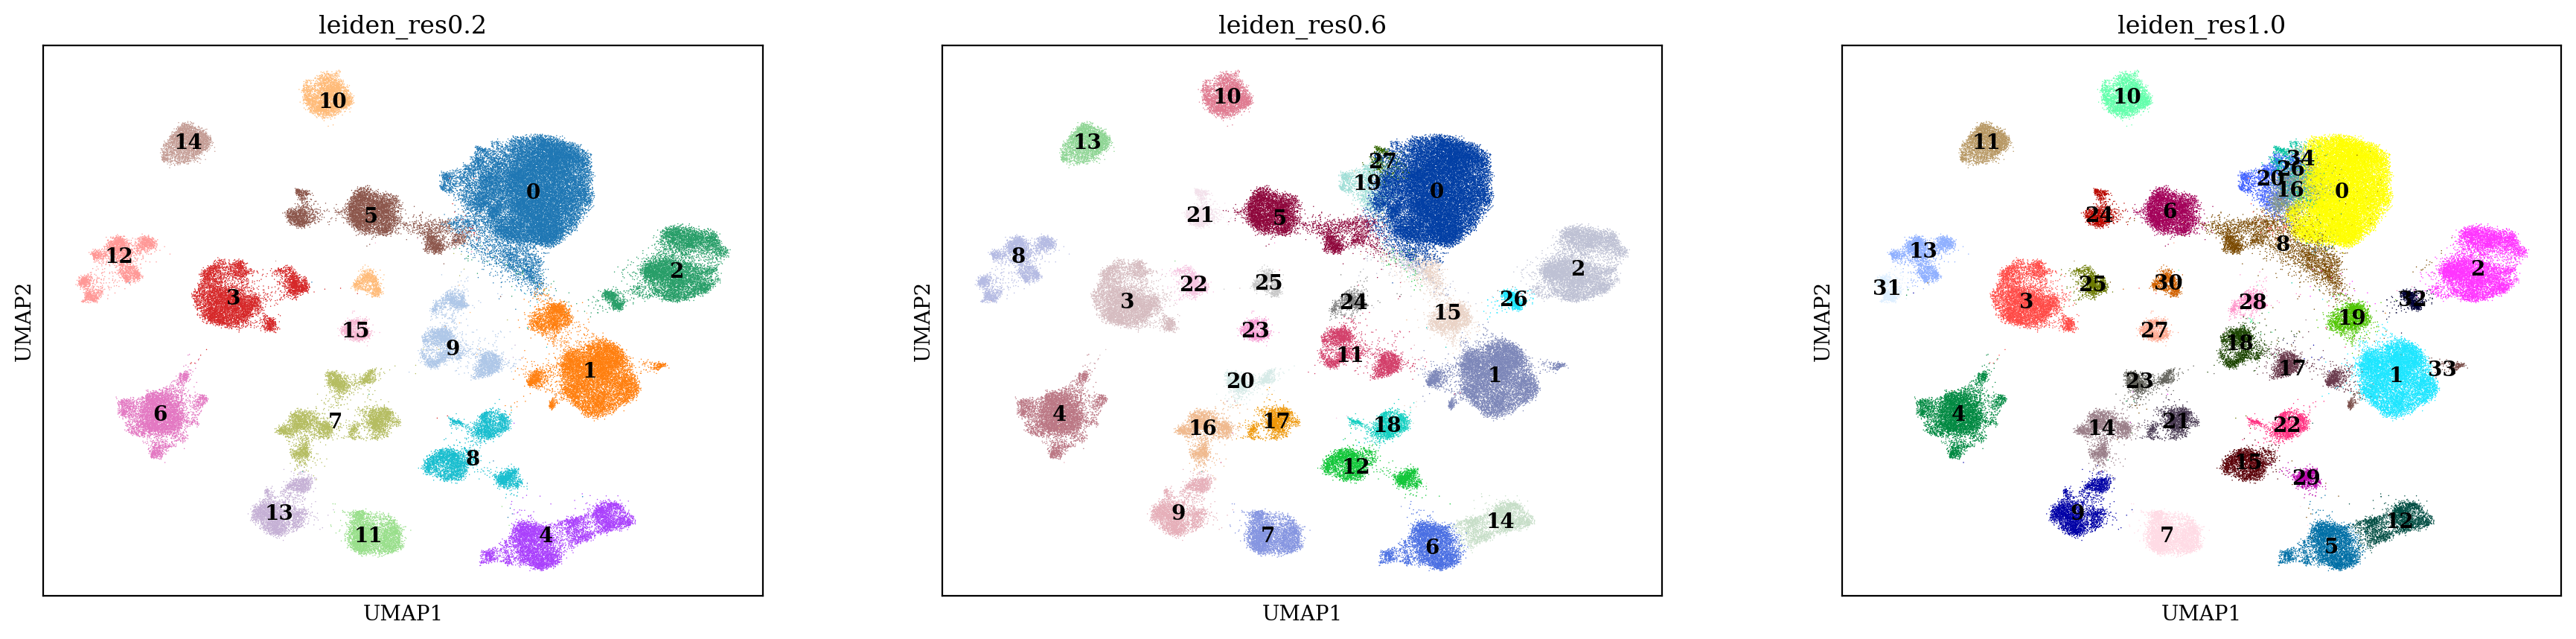

In [8]:
resolution = [resolution] if isinstance(resolution, (int, float)) else resolution
sc.pl.umap(
    latent,
    color=[f"leiden_res{res}" for res in resolution],
    legend_loc="on data",
)

### Reserved

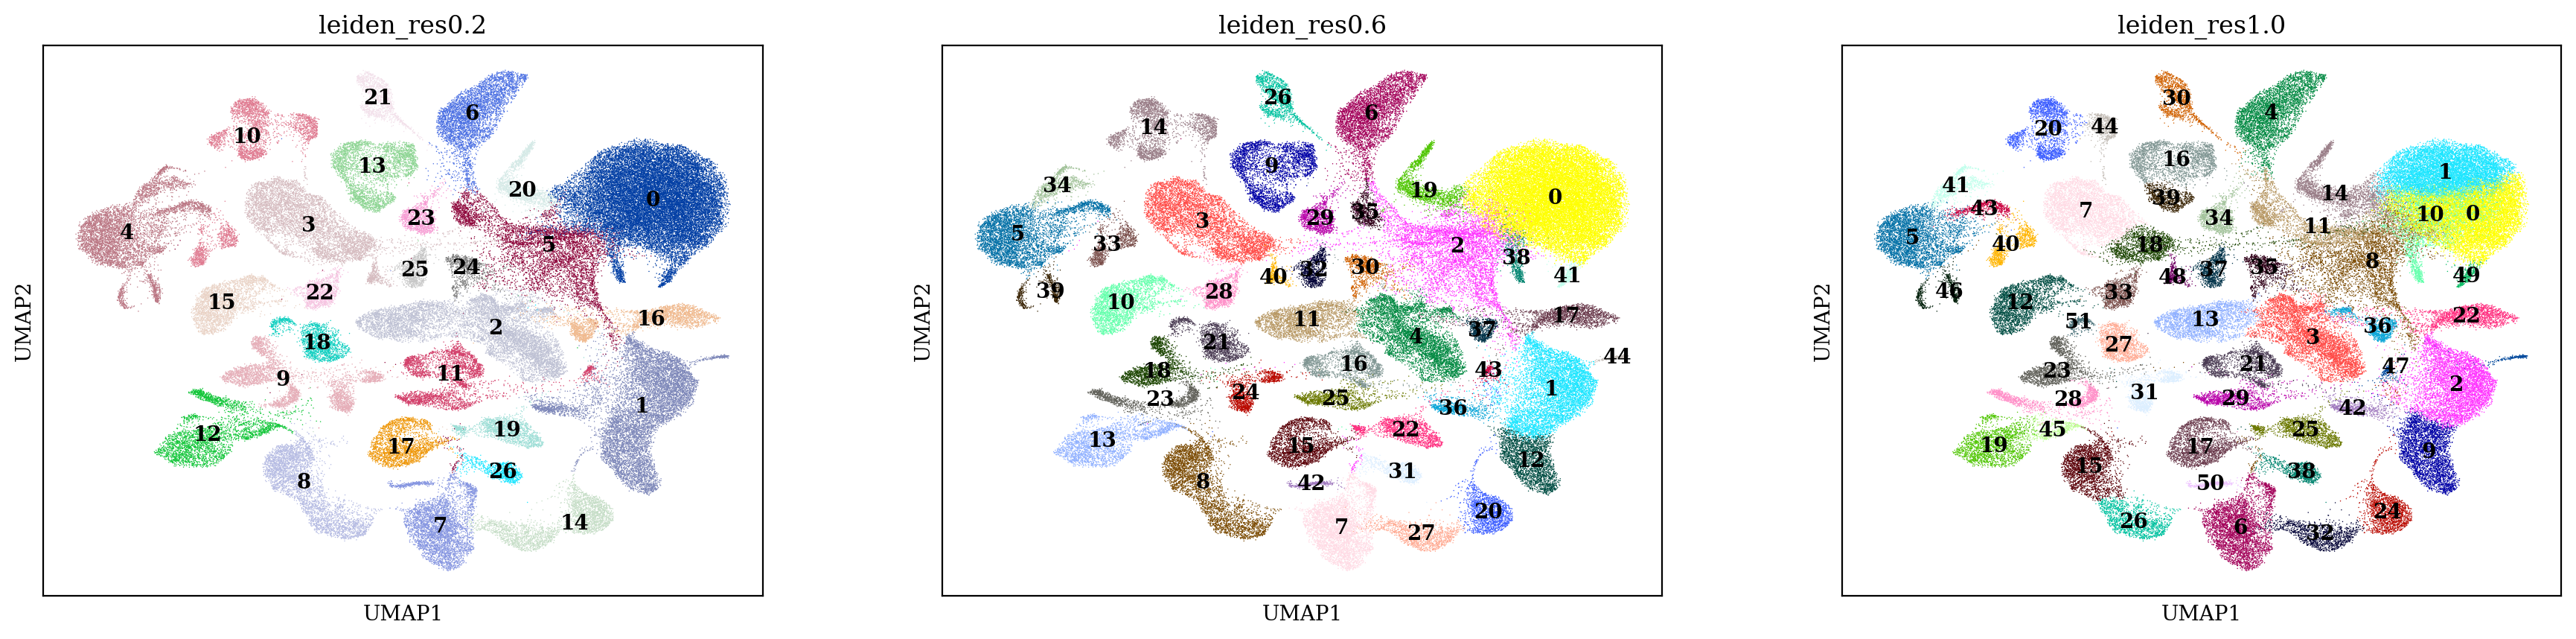

In [9]:
sc.pl.umap(
    reserved_latent,
    color=[f"leiden_res{res}" for res in resolution],
    legend_loc="on data",
)

### Unreserved

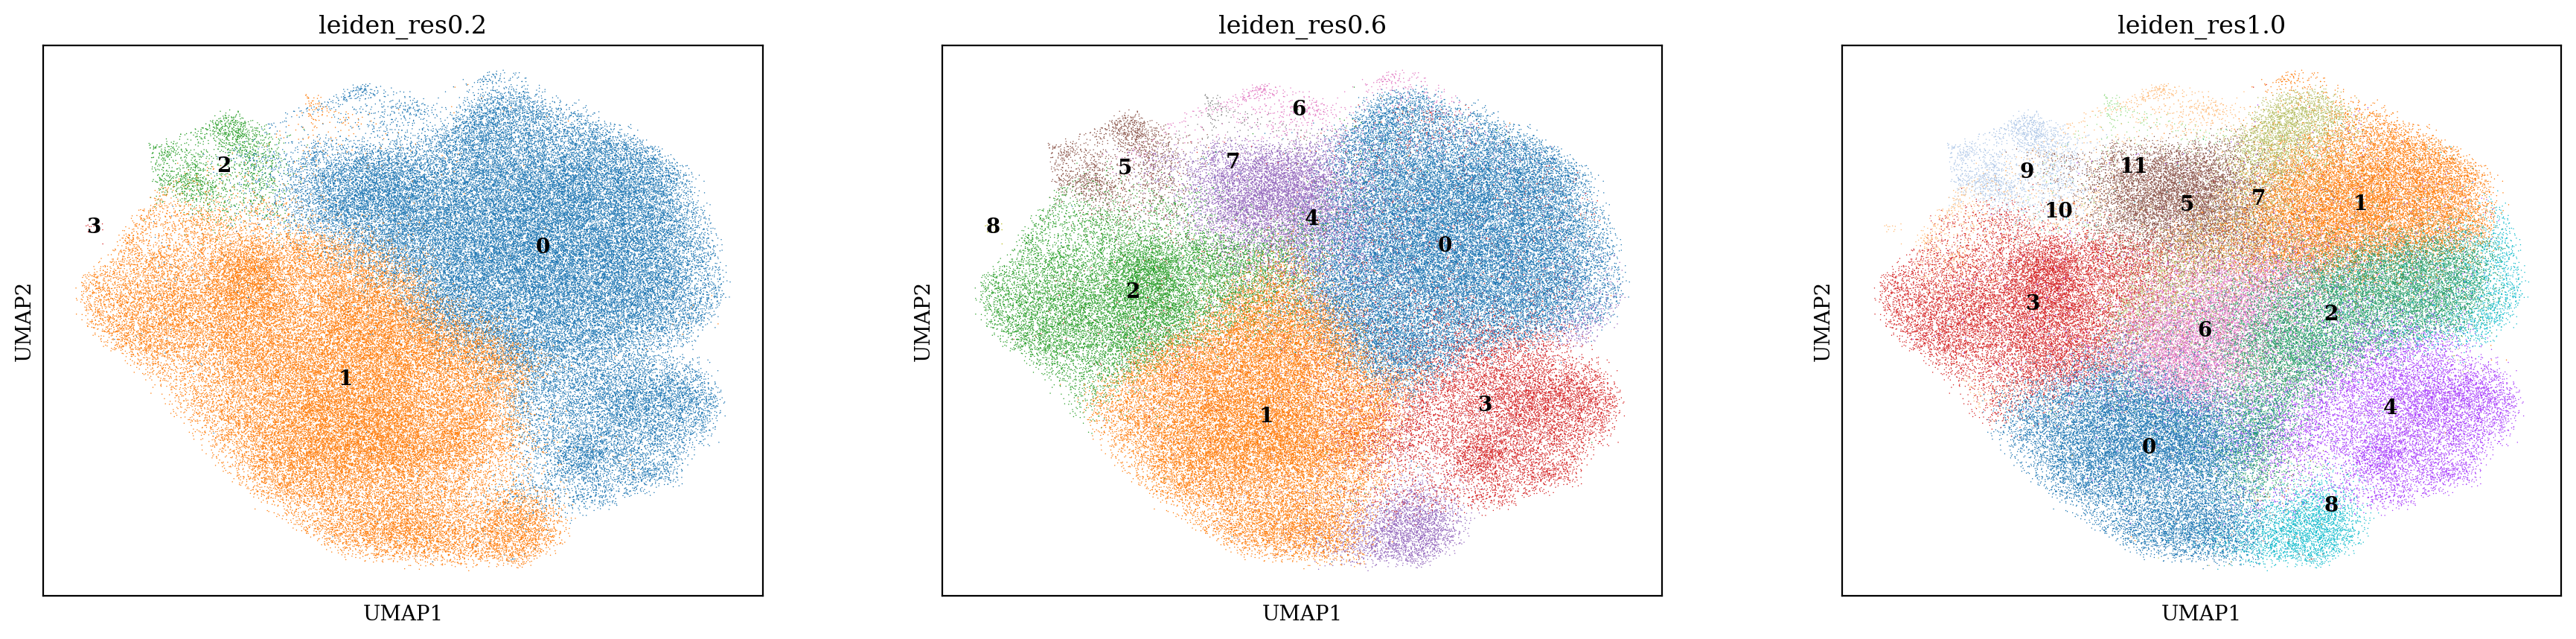

In [10]:
sc.pl.umap(
    unreserved_latent,
    color=[f"leiden_res{res}" for res in resolution],
    legend_loc="on data",
)

## Latent Space Visualization

In [11]:
def generate_random_colors(num_colors):
    return [
        "#" + "".join([np.random.choice(list("0123456789ABCDEF")) for j in range(6)])
        for i in range(num_colors)
    ]

In [12]:
unique_genes = set()
for genes in latent.obs["condition"].unique():
    unique_genes.update(genes.split("+"))

print(f"{len(unique_genes)} genes are used in the dataset.")

unique_conditions = latent.obs["condition"].unique()
colors = dict(zip(unique_conditions, generate_random_colors(len(unique_conditions))))
print(f"{len(unique_conditions)} conditions are used in the dataset.")

106 genes are used in the dataset.
284 conditions are used in the dataset.


In [13]:
np.random.seed(42)

def plot_latent(data, genes=None, n_genes=1, save_path=None, include_ctrl=True):
    if include_ctrl:
        control_points = data[data.obs["condition"] == "ctrl"]
        plotted_data = control_points.copy()
    else:
        plotted_data = None

    if genes is None:
        genes = np.random.choice(list(unique_genes), n_genes)

    for gene in genes:
        if plotted_data is not None:

            plotted_data = plotted_data.concatenate(
                data[data.obs["condition"] == f"{gene}+ctrl"]
            )
        else:
            plotted_data = data[data.obs["condition"] == f"{gene}+ctrl"]

        plotted_data = plotted_data.concatenate(
            data[data.obs["condition"] == f"ctrl+{gene}"]
        )

    title = f"Latent space of {', '.join(genes)}"
    sc.pl.umap(plotted_data, color="condition", title=title, save=save_path)

In [14]:
reserved_df = reserved_latent.obs["condition"].reset_index()
reserved_df[[f"latent{i}" for i in range(reserved_latent.X.shape[-1])]] = (
    reserved_latent.X
)
reserved_df["condition_without_duplicate"] = reserved_df["condition"].apply(
    lambda x: x[:-5] if x.endswith("+ctrl") else (x[5:] if x.startswith("ctrl+") else x)
)

In [15]:
reserved_df.groupby("condition_without_duplicate").mean()

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/1535495227.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reserved_df.groupby("condition_without_duplicate").mean()


latent0   latent1   latent2   latent3   latent4  \
condition_without_duplicate                                                     
AHR                          0.347741 -1.943156  1.695889  1.588690 -0.582995   
AHR+FEV                     -0.710553 -1.993893  2.557157 -0.097075 -1.099253   
AHR+KLF1                     1.089756 -0.384340  1.978664  0.409795  3.792501   
ARID1A                      -2.364035  1.990022 -0.429200  0.249560  0.390274   
ARRDC3                       2.498734 -0.521476 -0.230450 -3.156497  0.459333   
...                               ...       ...       ...       ...       ...   
ZC3HAV1+CEBPE                0.245640  0.816807 -1.295725 -0.667444  1.094162   
ZC3HAV1+HOXC13               0.457558 -1.375042  1.098935  2.621710 -0.887216   
ZNF318                       2.403644 -0.367760 -0.022683 -2.982717  0.682267   
ZNF318+FOXL2                -0.302936  1.197442  1.115994  1.433480 -3.199543   
ctrl                         2.481083 -0.543588 -0.276708 -3.237193  0.512385   

                              latent5   latent6   latent7  
condition_without_duplicate                                
AHR                          0.194300  3.652785 -1.405486  
AHR+FEV                     -0.007817  4.401598 -0.477851  
AHR+KLF1                     0.454522  2.536071 -2.998688  
ARID1A                      -1.091682  1.677521  0.983708  
ARRDC3                      -1.188322 -3.084624  0.174711  
...                               ...       ...       ...  
ZC3HAV1+CEBPE                4.571162 -1.690925  1.221634  
ZC3HAV1+HOXC13               1.138070  3.373258 -1.391074  
ZNF318                      -0.691181 -3.201860 -1.307214  
ZNF318+FOXL2                -0.534959 -1.424365 -2.516681  
ctrl                        -1.143045 -3.061047  0.151787  

[237 rows x 8 columns]

In [16]:
single_conditions = [
    cond
    for cond in reserved_df["condition_without_duplicate"].unique()
    if not "+" in cond and cond != "ctrl"
]
len(single_conditions)

105

In [17]:
def get_closest(target_mean_vector, mean_vectors, exclude=[], only_singles=False):
    closest_condition = None
    closest_distance = float("inf")

    for condition, mean_vector in mean_vectors.items():
        if only_singles and "ctrl" not in condition:
            continue

        if condition not in exclude:
            distance = euclidean(target_mean_vector, mean_vector)
            if distance < closest_distance:
                closest_distance = distance
                closest_condition = condition

    return closest_condition, closest_distance

In [18]:
mean_vectors = {
    condition: mean_vector.to_numpy()
    for condition, mean_vector in reserved_df.groupby("condition").mean().iterrows()
}

cov_vectors = {
    condition: var_vector.to_numpy()
    for condition, var_vector in reserved_df.groupby("condition").var().iterrows()
}

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/103421567.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for condition, mean_vector in reserved_df.groupby("condition").mean().iterrows()
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/103421567.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  for condition, var_vector in reserved_df.groupby("condition").var().iterrows()


In [19]:
n, n_single = 0, 0
symmetric_singles, symmetric_pairs = set([]), set([])
nonsymmetric_singles, nonsymmetric_pairs = {}, {}

for gene1, gene2 in list(itertools.product(unique_genes, unique_genes)):
    original_condition = f"{gene1}+{gene2}"
    expected = f"{gene2}+{gene1}"

    # Skip if the pair is already in the symmetric or nonsymmetric sets
    if original_condition in symmetric_pairs:
        continue

    if original_condition in nonsymmetric_pairs:
        continue

    # Skip if the mean vector of original or expected condition is not found
    if original_condition not in mean_vectors or expected not in mean_vectors:
        continue

    if original_condition in symmetric_singles:
        continue

    if original_condition in nonsymmetric_singles:
        continue

    closest_condition, closest_distance = get_closest(
        mean_vectors[original_condition], mean_vectors, exclude=[original_condition]
    )

    if closest_condition == expected:
        if "ctrl" in original_condition:
            symmetric_singles.add(original_condition)
        else:
            symmetric_pairs.add(original_condition)
    else:
        if "ctrl" in original_condition:
            nonsymmetric_singles[original_condition] = closest_condition
        else:
            nonsymmetric_pairs[original_condition] = closest_condition


n_expected_single = len(symmetric_singles)
n_expected = len(symmetric_pairs) + n_expected_single
n_single = len(nonsymmetric_singles) + n_expected_single
n = len(nonsymmetric_pairs) + n_single

print(f"{n_expected} out of {n} are expected.")
print(f"{n_expected_single} out of {n_single} are expected.")

if n == n_single:
    print("All are single.")

73 out of 94 are expected.
73 out of 94 are expected.
All are single.


In [20]:
new_nonsymmetric_singles = nonsymmetric_singles.copy()

for original, prev_closest in nonsymmetric_singles.items():
    gene = original.replace("ctrl+", "").replace("+ctrl", "")
    
    if "ctrl" in prev_closest:
        continue
    
    closest_condition, closest_distance = get_closest(
        mean_vectors[original], mean_vectors, exclude=[original], only_singles=True
    )

    if gene in closest_condition:
        new_nonsymmetric_singles.pop(original, None)
    else:
        new_nonsymmetric_singles[original] = (nonsymmetric_singles[original], closest_condition)

print(f"{len(nonsymmetric_singles) - len(new_nonsymmetric_singles)} singles are removed from nonsymmetric singles because they had been matched to conditions without control points.")
print(f"In fact, {len(new_nonsymmetric_singles)} out of {n_single} are not expected.")

6 singles are removed from nonsymmetric singles because they had been matched to conditions without control points.
In fact, 15 out of 94 are not expected.


In [21]:
new_nonsymmetric_singles

{'FOXA1+ctrl': 'FOXA3+ctrl',
 'KIF2C+ctrl': 'ARRDC3+ctrl',
 'ctrl+KIF2C': 'ARRDC3+ctrl',
 'ctrl+PTPN9': 'ctrl+UBASH3B',
 'ctrl+STIL': 'PLK4+ctrl',
 'ctrl+MAP7D1': 'BCL2L11+ctrl',
 'ctrl+FOXF1': 'ctrl+MEIS1',
 'ctrl+UBASH3A': 'ctrl',
 'PTPN9+ctrl': 'UBASH3B+ctrl',
 'STIL+ctrl': 'ARRDC3+ctrl',
 'MAP7D1+ctrl': 'ctrl+SLC38A2',
 'RUNX1T1+ctrl': 'ctrl+CBFA2T3',
 'FOXL2+ctrl': ('FOXL2+MEIS1', 'C3orf72+ctrl'),
 'BAK1+ctrl': ('BCL2L11+BAK1', 'BCL2L11+ctrl'),
 'FOXF1+ctrl': 'BCORL1+ctrl'}

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4245765400.py:16: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  plotted_data = plotted_data.concatenate(
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4245765400.py:22: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  plotted_data = plotted_data.concatenate(
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4245765400.py:16: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concat

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4245765400.py:22: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  plotted_data = plotted_data.concatenate(


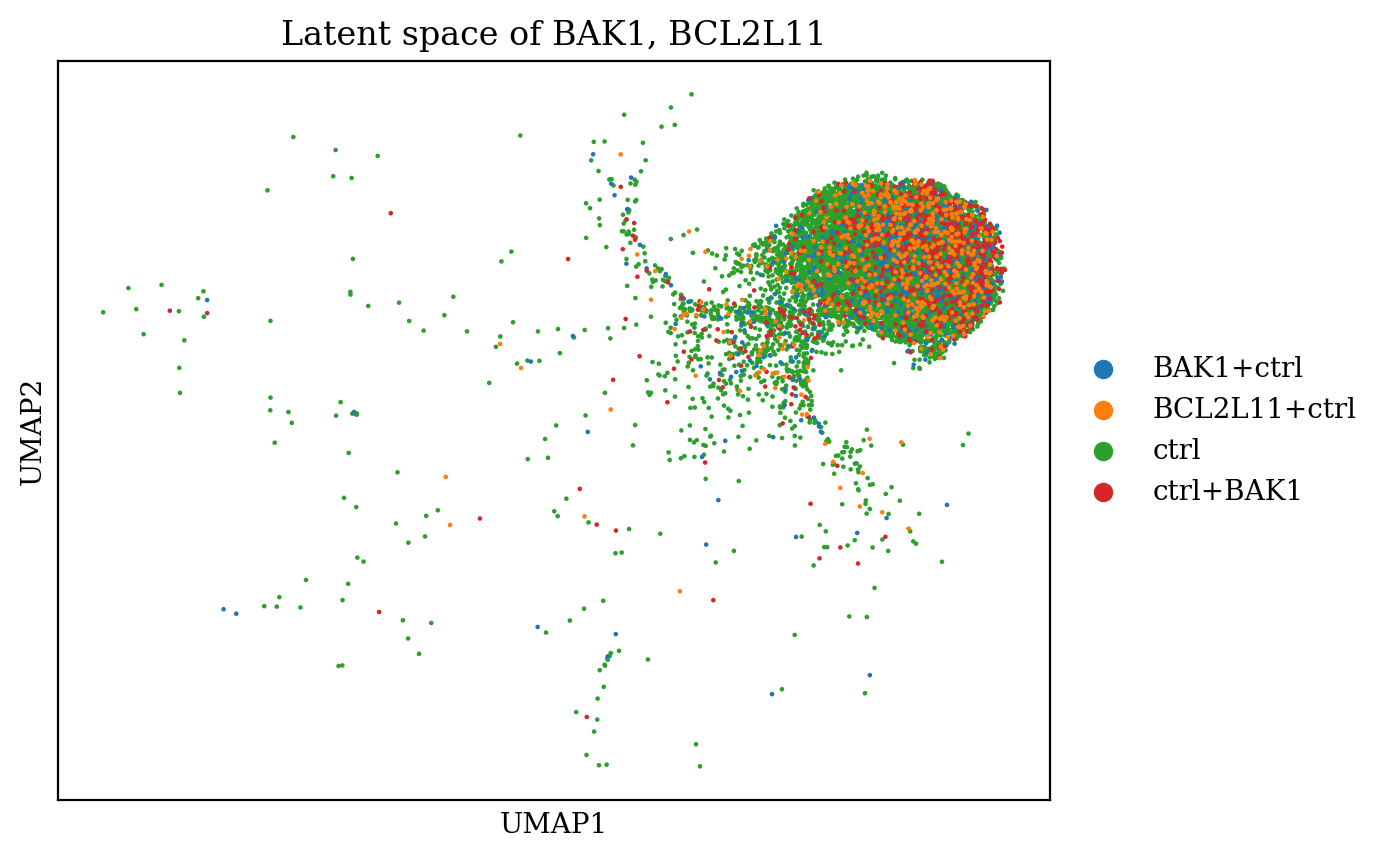

In [22]:
genes = ["BAK1", "BCL2L11"]
plot_latent(reserved_latent, genes=genes, save_path=None, include_ctrl=True)

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4245765400.py:16: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  plotted_data = plotted_data.concatenate(
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4245765400.py:22: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  plotted_data = plotted_data.concatenate(
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/4245765400.py:16: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concat

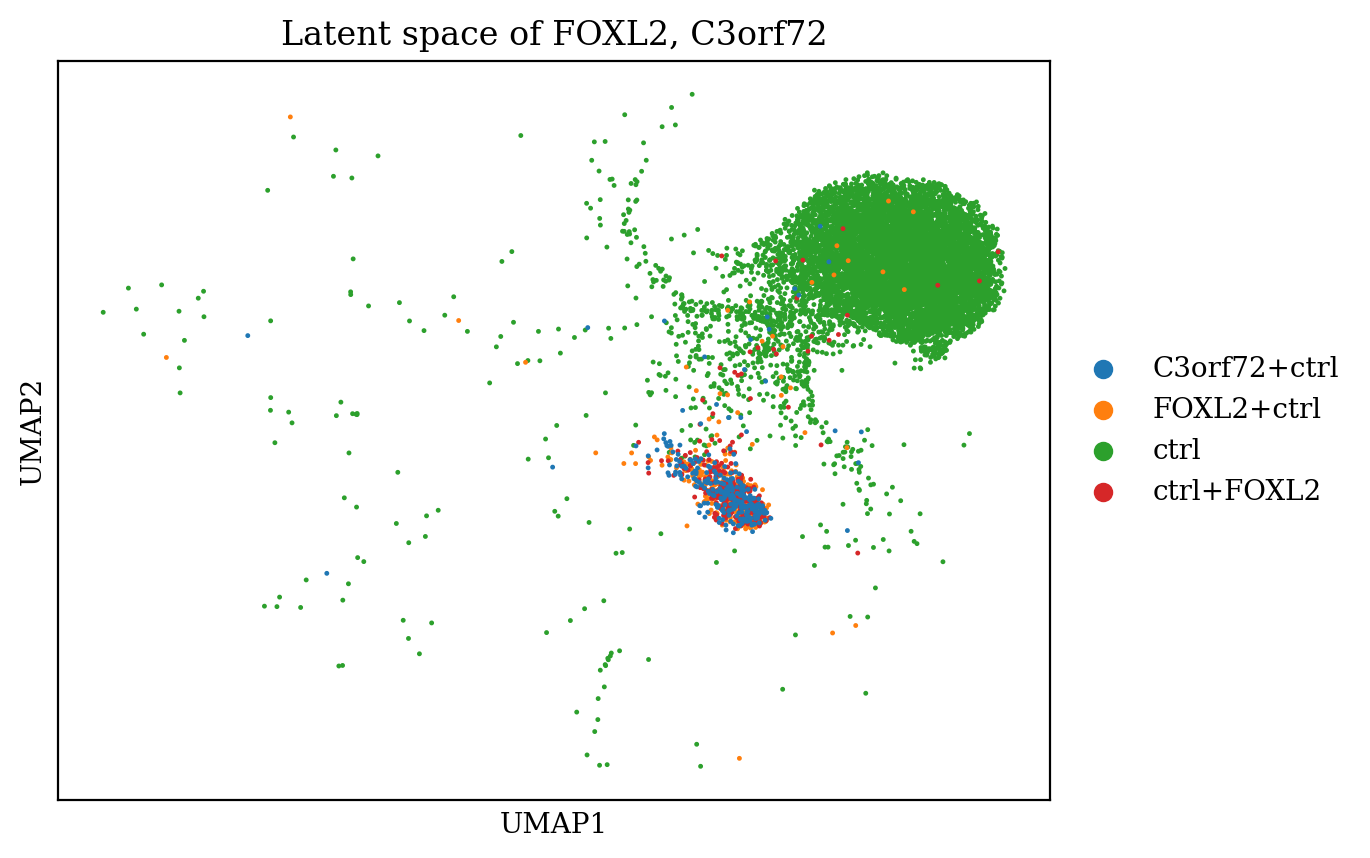

In [23]:
genes = ["FOXL2", "C3orf72"]
plot_latent(reserved_latent, genes=genes, save_path=None, include_ctrl=True)

In [24]:
mean_without_duplicate = {
    condition: mean_vector.to_numpy()
    for condition, mean_vector in reserved_df.groupby("condition_without_duplicate")
    .mean()
    .iterrows()
}
cov_without_duplicate = {
    condition: cov_vector.to_numpy()
    for condition, cov_vector in reserved_df.groupby("condition_without_duplicate")
    .var()
    .iterrows()
}

/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/1211500885.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/var/folders/24/jbn800492ks0n353ktq87jp00000gn/T/ipykernel_2969/1211500885.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .var()


In [25]:
mean_single = {gene: mean_without_duplicate[gene] for gene in single_conditions}
mean_pairs = {
    condition: mean_without_duplicate[condition] - mean_without_duplicate["ctrl"]
    for condition in mean_without_duplicate.keys()
    if condition not in unique_genes
}
cov_single = {gene:cov_without_duplicate[gene] for gene in single_conditions}
cov_pairs = {
    condition: cov_without_duplicate[condition] - cov_without_duplicate["ctrl"]
    for condition in cov_without_duplicate.keys()
    if condition not in unique_genes
}

In [26]:
n_linear, n_total = 0, 0
tolerance = 0.1 

for pair in mean_pairs.keys():
    gene1, gene2 = pair.split("+")
    if gene1 in mean_single and gene2 in mean_single:
        expected_mean_vector = (
            mean_single[gene1] + mean_single[gene2] - mean_without_duplicate["ctrl"] * 2
        )

        closest_condition, closest_distance = get_closest(
            expected_mean_vector, mean_pairs
        )
        if pair != closest_condition:
            
            expected_distance = euclidean(expected_mean_vector, mean_pairs[pair])
            diff = (expected_distance - closest_distance) / expected_distance
            if diff < tolerance:
                n_linear += 1
        else:
            n_linear += 1
        
        n_total += 1

print(f"{n_linear} out of {n_total} are linear.")

111 out of 131 are linear.


In [46]:
X_adata_ref = []
conditions = []

for pair in mean_pairs.keys():
    gene1, gene2 = pair.split("+")
    if gene1 in mean_single and gene2 in mean_single:
        expected_mean_vector = (
            mean_single[gene1] + mean_single[gene2] - mean_without_duplicate["ctrl"] * 2
        )
        X_adata_ref.append(expected_mean_vector)
        conditions.append([f"{gene1}+{gene2}"])

In [49]:
adata_ref = ad.AnnData(np.array(X_adata_ref), obs=pd.DataFrame(conditions, columns=["condition"]))

/Users/aleynakara/mamba/envs/tardis_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [29]:
from typing import List

def label_transfer(
    reference_embeddings: ad.AnnData,
    query_embeddings: ad.AnnData,
    cluster_list: List[str],
    neighbors_count: int,
):
    # Compute a joint neighbor graph for reference and query embeddings
    joint_graph = sc.tools.Ingest(reference_embeddings)
    joint_graph.fit(query_embeddings)
    joint_graph.neighbors(k=neighbors_count)

    # Calculate distances to top neighbors_count neighbors for each cell and store indices
    top_neighbor_distances, top_neighbor_indices = (
        joint_graph._distances,
        joint_graph._indices,
    )

    # Transform distances with Gaussian kernel
    distance_stds = np.std(top_neighbor_distances, axis=1)
    distance_stds = (2.0 / distance_stds) ** 2
    distance_stds = distance_stds.reshape(-1, 1)
    transformed_distances = np.exp(
        -np.true_divide(top_neighbor_distances, distance_stds)
    )

    # Normalize transformed distances so that they sum to 1
    normalized_weights = transformed_distances / np.sum(
        transformed_distances, axis=1, keepdims=True
    )

    # Initialize empty series to store predicted labels and uncertainties for each query cell
    cell_uncertainties = pd.Series(
        index=query_embeddings.obs_names, dtype="float64"
    )
    predicted_labels = pd.Series(index=query_embeddings.obs_names, dtype="object")

    # Iterate through query cells
    for cluster in cluster_list:
        train_labels = reference_embeddings.obs[cluster].values
        for index in range(len(normalized_weights)):
            # Store cell types present among neighbors in reference
            unique_cell_types = np.unique(train_labels[top_neighbor_indices[index]])

            # Store best label and corresponding probability
            best_cell_type, best_probability = None, 0.0

            # Iterate through all cell types present among the cell's neighbors
            for label in unique_cell_types:
                prob = normalized_weights[
                    index, train_labels[top_neighbor_indices[index]] == label
                ].sum()
                if best_probability < prob:
                    best_probability = prob
                    best_cell_type = label
            else:
                final_label = best_cell_type

            # Store best label and corresponding uncertainty
            cell_uncertainties.iloc[index] = max(1 - best_probability, 0)
            predicted_labels.iloc[index] = final_label

        query_embeddings.obs[f"transf_{cluster}"] = predicted_labels
        query_embeddings.obs[f"transf_{cluster}_unc"] = cell_uncertainties

In [77]:
resolution = 1.0
neighbors_count = 30

label_transfer(
    reserved_latent,
    adata_ref,
    [f"leiden_res{resolution}"],
    neighbors_count,
)

/Users/aleynakara/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [90]:
most_common_labels = {}
n_clusters = len(reserved_latent.obs[f'leiden_res{resolution}'].unique())

for cluster_id in range(n_clusters):
    # Get indices of data points in current cluster
    cluster_indices = reserved_latent.obs[f'leiden_res{resolution}']== str(cluster_id)
    # Get labels of data points in current cluster
    cluster_labels_in_cluster = reserved_latent[cluster_indices].obs["condition"]
    # Count occurrences of each label
    label_counts = cluster_labels_in_cluster.value_counts()
    # Get the most common label
    most_common_label = label_counts.idxmax()
    # Store the most common label for this cluster
    most_common_labels[str(cluster_id)] = most_common_label


In [73]:
reserved_latent.obs[f'leiden_res{resolution}']== str(cluster_id)

index
AAACCTGAGAAGAAGC-1    False
AAACCTGAGGCATGTG-1    False
AAACCTGAGGCCCTTG-1    False
AAACCTGCACGAAGCA-1    False
AAACCTGCAGACGTAG-1    False
                      ...  
TTTGTCATCAGTACGT-8    False
TTTGTCATCCACTCCA-8    False
TTTGTCATCCCAACGG-8     True
TTTGTCATCCTCCTAG-8    False
TTTGTCATCTGGCGAC-8    False
Name: leiden_res1.0, Length: 108497, dtype: bool

In [92]:
adata_ref.obs[f"transf_leiden_res{resolution}"] = adata_ref.obs[f"transf_leiden_res{resolution}"].apply(lambda cluster_id: most_common_labels[str(cluster_id)])

In [93]:
(adata_ref.obs[f"transf_leiden_res{resolution}"] == adata_ref.obs[f"condition"]).sum()

9